In [114]:
!pip install eTaPR-1.12-py3-none-any.whl

In [115]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [116]:
TRAIN_DATASET = sorted([x for x in Path(".").glob("train*.csv")])
TRAIN_DATASET

[PosixPath('train1.csv'), PosixPath('train2.csv'), PosixPath('train3.csv')]

In [117]:
TEST_DATASET = sorted([x for x in Path(".").glob("test*.csv")])
TEST_DATASET

[PosixPath('test1.csv'),
 PosixPath('test2.csv'),
 PosixPath('test3.csv'),
 PosixPath('test4.csv')]

In [118]:
VALIDATION_DATASET = sorted([x for x in Path(".").glob("validation.csv")])
VALIDATION_DATASET

[PosixPath('validation.csv')]

In [119]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [120]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,-3.0660,-0.00297,301.01636,40.49072,10,1000.44769,397.63785,4795.0,0,1,16495.0,0,1,4.01474,15454.0,763.19324,246.43968,8.46252,0,1.29784,35.74219,1973.19031,10052.0,10,1,1,100.0,10,1001.99799,37.14706,0,100.0,815.0,20,4.1758,166.74039,11.89504,54074.0,0,780.0,608.0,1,0,-0.00072,100.0,51.58201,2847.02539,0.27786,0.06511,70,2847.02539,540833,712.07275,540833,1,2880,39.09198,0,0.10121,27610.0,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,-2.9721,0.00072,297.43567,40.49072,10,1000.01270,397.63785,4835.0,0,1,16402.0,0,1,3.74347,15461.0,763.19324,246.43968,8.47015,0,1.29692,35.74219,1975.47900,10052.0,10,1,1,100.0,10,1001.99799,37.14477,0,100.0,883.0,20,3.9259,168.64778,11.93421,54089.0,0,781.0,528.0,1,0,-0.00051,100.0,51.60648,2839.58520,0.27634,0.04340,70,2839.58520,540833,708.52661,540833,1,2880,39.05680,0,0.10121,27610.0,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,-2.9857,-0.00145,298.84619,40.49835,10,1000.88245,397.63785,4961.0,0,1,16379.0,0,1,3.43603,15462.0,763.19324,246.05821,8.47015,0,1.29631,35.74219,1972.42725,10050.0,10,1,1,100.0,10,1001.99799,37.14325,0,100.0,956.0,20,3.6489,168.83849,11.97030,54124.0,0,780.0,464.0,1,0,-0.00043,100.0,51.57790,2833.26807,0.27634,0.04340,70,2833.26807,540833,709.15527,540833,1,2880,38.97124,0,0.10121,27617.0,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,-3.2166,-0.00318,297.74310,40.49072,10,1000.88245,397.63785,5022.0,0,1,16422.0,0,1,3.12860,15466.0,763.19324,246.63045,8.46252,0,1.28685,35.74219,1983.10828,10052.0,10,1,1,100.0,10,1001.99799,37.11959,0,100.0,992.0,20,3.3040,170.55510,12.01066,54099.0,0,780.0,416.0,1,0,-0.00072,100.0,51.58236,2834.95264,0.27634,0.02170,70,2834.95264,540833,715.46631,540833,1,2880,38.94103,0,0.10121,27614.0,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,-3.5613,0.00015,297.01965,40.49835,10,1000.01270,397.63785,5088.0,0,1,16355.0,0,1,2.87546,15461.0,763.19324,246.24898,8.47015,0,1.28807,35.74219,1986.16016,10052.0,10,1,1,100.0,10,1001.99799,37.12265,0,100.0,1074.0,20,3.1881,171.31805,11.99684,54094.0,0,782.0,368.0,1,0,-0.00051,100.0,51.62335,2832.70654,0.27710,0.02170,70,2832.70654,540833,709.22852,540833,1,2880,38.90300,0,0.10121,27621.0,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,-2.6936,0.00130,359.39307,52.49939,10,1107.37695,386.60074,-22.0,0,1,17069.0,0,1,64.86902,16460.0,763.19324,309.02856,15.00092,0,1.36711,35.34546,1958.69434,10027.0,10,1,1,100.0,10,1109.47327,35.66360,0,100.0,-20.0,20,4.6991,219.95543,11.92414,54121.0,0,782.0,13728.0,1,0,0.00022,100.0,66.63997,2830.03906,0.27557,62.55063,70,2825.96826,540833,716.41846,540833,1,2880,52.09266,0,0.10167,27586.0,944.84705,0.0,1.32843,15.17817,

In [121]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [122]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [123]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [124]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.95).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,0.481272,0.260132,0.200820,0.0,0.478068,0.357101,0.881536,0.0,0.0,0.270592,0.0,0.0,0.045701,0.708779,0.0,0.406877,0.289495,0.0,0.317237,0.139665,0.983325,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661946,0.0,1.0,0.215404,0.0,0.642237,0.373146,0.444904,0.465909,0.0,0.392405,0.047904,0.0,0.0,0.574348,1.0,0.206193,0.996286,0.049420,0.000870,0.0,0.996286,0.0,0.480318,0.0,0.0,0.0,0.189004,0.0,0.989609,0.808081,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378482,0.0,0.0,0.226573,0.352618,0.000157,0.399662,0.362217,0.794615,0.542085,0.515461,0.247437,0.200820,0.0,0.476598,0.357101,0.888500,0.0,0.0,0.264399,0.0,0.0,0.042720,0.709233,0.0,0.406877,0.289752,0.0,0.316444,0.139665,0.984414,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661456,0.0,1.0,0.232031,0.0,0.555369,0.376863,0.568237,0.520022,0.0,0.404461,0.043831,0.0,0.0,0.576697,1.0,0.207011,0.993784,0.048755,0.000622,0.0,0.993784,0.0,0.452499,0.0,0.0,0.0,0.188558,0.0,0.989609,0.808081,0.592385,0.0,0.326835,0.254297,0.337516,0.916661,0.266667,0.251162,1.00000,0.509510
2,0.378460,0.0,0.0,0.226798,0.316714,0.000154,0.392996,0.456390,0.804460,0.538784,0.497028,0.251823,0.200917,0.0,0.479460,0.357101,0.910717,0.0,0.0,0.262576,0.0,0.0,0.039208,0.709319,0.0,0.404390,0.289764,0.0,0.315882,0.139665,0.983017,0.327163,0.0,0.0,0.0,1.0,0.0,0.482697,0.661108,0.0,1.0,0.250628,0.0,0.455183,0.377411,0.687462,0.648555,0.0,0.393006,0.040386,0.0,0.0,0.577702,1.0,0.206097,0.991546,0.048723,0.000610,0.0,0.991546,0.0,0.456098,0.0,0.0,0.0,0.187454,0.0,0.989609,0.875261,0.595731,0.0,0.326362,0.255358,0.337822,0.916661,0.265177,0.254835,1.00000,0.467169
3,0.378928,0.0,0.0,0.226809,0.234255,0.000154,0.393705,0.316399,0.814297,0.455135,0.480119,0.248141,0.200824,0.0,0.479603,0.357101,0.922419,0.0,0.0,0.265342,0.0,0.0,0.035662,0.709582,0.0,0.407996,0.289508,0.0,0.307721,0.139665,0.988017,0.331502,0.0,0.0,0.0,1.0,0.0,0.482697,0.656038,0.0,1.0,0.260336,0.0,0.330595,0.380775,0.820173,0.565003,0.0,0.392435,0.037776,0.0,0.0,0.574516,1.0,0.206200,0.992000,0.048722,0.000361,0.0,0.992000,0.0,0.505662,0.0,0.0,0.0,0.187017,0.0,0.989609,0.849823,0.596196,0.0,0.326339,0.257478,0.331414,0.916661,0.264326,0.252917,1.00000,0.444868
4,0.380360,0.0,0.0,0.226810,0.161513,0.000154,0.413857,0.672240,0.823585,0.326323,0.510050,0.245398,0.200917,0.0,0.476678,0.357101,0.934466,0.0,0.0,0.261030,0.0,0.0,0.032710,0.709272,0.0,0.405690,0.289752,0.0,0.308362,0.139665,0.989715,0.331719,0.0,0.0,0.0,1.0,0.0,0.482697,0.656438,0.0,1.0,0.280822,0.0,0.284179,0.382427,0.783401,0.542833,0.0,0.416457,0.035208,0.0,0.0,0.576700,1.0,0.207573,0.991269,0.049053,0.000349,0.0,0.991269,0.0,0.459329,0.0,0.0,0.0,0.186514,0.0,0.989609,0.915724,0.598910,0.0,0.326811,0.256260,0.337517,0.916661,0.262664,0.247407,1.00000,0.479152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302372,0.0,0.0,0.703684,0.509852,0.000538,0.418265,0.345194,0.064419,0.644807,0.522091,0.478403,0.362090,0.0,0.857592,0.215741,0.000915,0.0,0.0,0.311452,0.0,0.0,0.748195,0.777427,0.0,0.836331,0.520956,0.0,0.379907,0.066906,0.976329,0.271521,0.0,0.0,0.0,1.0,0.0,0.946227,0.328469,0.0,1.0,0.001027,0.0,0.836919,0.482223,0.535930,0.639808,0.0,0.420195,0.749584,0.0,0.0,0.585260,1.0,0.734919,0.990213,0.048368,0.753037,0.0,0.988779,0.0,0.513385,0.0,0.0,0.0,0.362097,0.0,0.995982,0.564171,0.683423,0

In [125]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [126]:
boundary_check(TRAIN_DF)

(False, False, False)

In [127]:
WINDOW_GIVEN = 119
WINDOW_SIZE = 120


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [128]:
TRAIN_DF_RAW,TRAIN_DF

(                       time        C01  C02  ...        C77      C78     C79
 0       2020-07-11 00:00:00  395.19528   12  ...  301.35992  33.6555  6.0951
 1       2020-07-11 00:00:01  395.14420   12  ...  297.43567  33.6555  5.9262
 2       2020-07-11 00:00:02  395.14420   12  ...  298.66534  33.6555  5.8101
 3       2020-07-11 00:00:03  395.19528   12  ...  298.06860  33.6555  5.7509
 4       2020-07-11 00:00:04  395.34866   12  ...  296.53137  33.6555  5.8547
 ...                     ...        ...  ...  ...        ...      ...     ...
 478796  2020-08-10 10:59:56  387.27219   12  ...  296.54950  32.0000  6.6026
 478797  2020-08-10 10:59:57  387.52774   12  ...  296.15161  32.0000  6.3894
 478798  2020-08-10 10:59:58  387.47665   12  ...  293.40277  32.0000  6.2584
 478799  2020-08-10 10:59:59  387.73221   12  ...  302.58972  32.0000  6.4150
 478800  2020-08-10 11:00:00  387.52774   12  ...  309.00964  32.0000  6.6288
 
 [921603 rows x 80 columns],
              C01  C02  C03      

In [129]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=6)
HAI_DATASET_TRAIN[0]


# of valid windows: 153541


{'answer': tensor([3.8034e-01, 0.0000e+00, 0.0000e+00, 2.2681e-01, 3.6842e-01, 1.5745e-04,
         3.6522e-01, 3.6375e-01, 9.4574e-02, 4.0097e-01, 5.2393e-01, 3.2333e-01,
         1.6261e-01, 0.0000e+00, 4.7814e-01, 3.5710e-01, 1.1056e-03, 0.0000e+00,
         0.0000e+00, 3.1173e-01, 0.0000e+00, 0.0000e+00, 2.9489e-01, 9.5246e-01,
         0.0000e+00, 4.0911e-01, 3.6943e-01, 0.0000e+00, 3.6787e-01, 1.3687e-01,
         9.8142e-01, 2.6923e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.8270e-01, 6.9340e-01, 0.0000e+00, 1.0000e+00, 1.2837e-03,
         0.0000e+00, 7.1669e-01, 3.8064e-01, 2.9107e-01, 5.5025e-01, 0.0000e+00,
         3.6585e-01, 2.8095e-01, 0.0000e+00, 0.0000e+00, 5.9529e-01, 1.0000e+00,
         2.3537e-01, 9.9415e-01, 4.8402e-02, 1.7463e-01, 0.0000e+00, 9.9415e-01,
         0.0000e+00, 3.6301e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7280e-01,
         0.0000e+00, 9.8961e-01, 8.2879e-01, 5.9394e-01, 0.0000e+00, 2.8438e-01,
         3.6571e-0

In [130]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 512


class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [131]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): LSTM(79, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=79, bias=True)
)

In [132]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [133]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 100)


CPU times: user 53min 40s, sys: 17min 37s, total: 1h 11min 17s
Wall time: 1h 11min 29s


In [134]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.10900195818976499, 98)

In [135]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [136]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

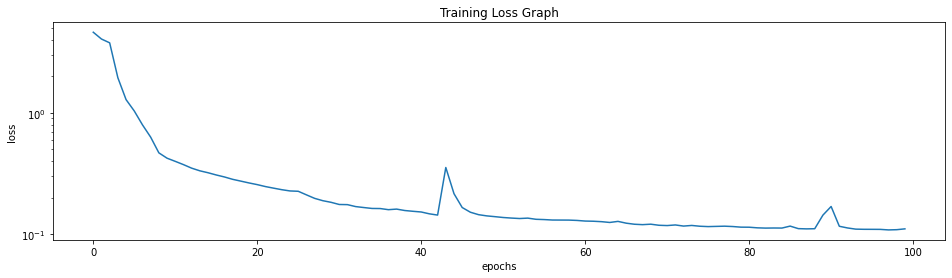

In [137]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [138]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,-2.8687,0.00470,464.06610,41.32233,10,989.14117,403.78854,-25.0,0,1,20469.0,0,1,73.58581,18082.0,763.19324,243.38802,10.84290,0,1.58771,35.14710,1978.72156,10044.0,10,1,1,100.00000,10,985.37353,36.81010,...,99.91608,-23.0,20,3.7751,176.08643,11.91040,54116.0,0,790.0,15888,1,0,0.00029,100.00000,50.90726,2843.37549,0.27557,76.80121,70,2839.58520,540833,725.21362,540833,1,2880,40.74125,0,0.10178,27567.0,845.69550,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,-2.9842,0.00210,464.22888,41.32233,10,992.62018,403.78854,-25.0,0,1,20489.0,0,1,73.89325,18043.0,763.19324,243.00656,10.84290,0,1.58725,35.14710,1986.92322,10040.0,10,1,1,100.00000,10,985.37353,36.80895,...,99.91608,-23.0,20,3.1689,173.79756,11.98856,54114.0,0,789.0,15952,1,0,0.00051,100.00000,50.74607,2845.06006,0.27710,76.92419,70,2843.37549,540833,721.74072,540833,1,2880,40.86124,0,0.10178,27564.0,840.47705,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,-3.4939,0.00130,466.90533,41.32233,10,993.92468,403.78854,-25.0,0,1,20604.0,0,1,74.20068,18024.0,763.19324,242.81586,10.84290,0,1.59519,35.14710,1978.72156,10037.0,10,1,1,100.00000,10,985.37353,36.82879,...,99.91608,-23.0,20,2.9615,174.56052,11.97400,54082.0,0,786.0,16000,1,0,0.00022,100.00000,50.66229,2837.33911,0.27710,77.04715,70,2845.06006,540833,718.15796,540833,1,2880,41.02906,0,0.10178,27565.0,835.25842,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,-3.8188,0.00000,466.79688,41.32233,10,993.05493,403.78854,-25.0,0,1,20633.0,0,1,74.43579,17985.0,763.19324,242.43439,10.84290,0,1.59747,35.14710,1977.76782,10040.0,10,1,1,100.00000,10,985.37353,36.83451,...,99.91608,-23.0,20,3.1285,176.65860,11.92999,54109.0,0,785.0,16064,1,0,0.00022,100.00000,50.66462,2843.37549,0.27557,77.17014,70,2837.33911,540833,716.38794,540833,1,2880,41.15958,0,0.10178,27560.0,836.99799,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,-3.9858,-0.00043,467.88190,41.21552,10,992.62018,403.78854,-25.0,0,1,20738.0,0,1,74.74322,17954.0,763.19324,242.81586,10.84290,0,1.59869,35.14710,1972.42725,10042.0,10,1,1,100.00000,10,985.37353,36.83756,...,99.90845,-23.0,20,3.4986,175.89565,11.86934,54111.0,0,783.0,16112,1,0,0.00000,100.00000,50.65214,2837.33911,0.27710,77.29312,70,2843.37549,540833,714.66675,540833,1,2880,41.28887,0,0.10178,27564.0,841.78162,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,-3.9067,0.00195,473.27112,98.47412,10,1116.89392,395.43826,-9.0,0,1,21044.0,0,1,77.45587,17622.0,763.19324,313.19473,15.69519,10,1.61632,35.60485,1471.74841,10053.0,10,1,1,79.42770,10,1115.26257,36.10442,...,37.21771,-21.0,20,3.1597,219.57394,11.79042,54115.0,50,787.0,16656,1,0,0.00000,37.51368,66.38953,2440.14233,0.82565,78.65308,70,2440.14233,5408

In [139]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [140]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [141]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 43082


{'answer': tensor([5.0099e-01, 0.0000e+00, 0.0000e+00, 1.7481e-01, 2.9587e-01, 3.0731e-04,
         4.2806e-01, 2.5797e-01, 5.7870e-04, 1.9646e-01, 4.9188e-01, 7.2836e-01,
         2.5512e-01, 0.0000e+00, 4.2098e-01, 4.3588e-01, 3.3090e-02, 0.0000e+00,
         0.0000e+00, 4.0540e-01, 0.0000e+00, 0.0000e+00, 7.6127e-01, 6.2065e-01,
         0.0000e+00, 3.5714e-01, 2.6897e-01, 0.0000e+00, 4.2076e-01, 2.7931e-02,
         9.8437e-01, 3.3413e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.8759e-01, 0.0000e+00, 9.9916e-01, 2.5674e-04,
         0.0000e+00, 5.7570e-01, 3.8642e-01, 1.4524e-01, 6.0227e-01, 0.0000e+00,
         4.3038e-01, 7.7759e-01, 0.0000e+00, 0.0000e+00, 5.8022e-01, 1.0000e+00,
         1.5259e-01, 9.9262e-01, 4.9071e-02, 8.2592e-01, 0.0000e+00, 9.9153e-01,
         0.0000e+00, 4.4633e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6248e-01,
         0.0000e+00, 9.9751e-01, 3.5354e-01, 6.0440e-01, 0.0000e+00, 3.5133e-01,
         2.0199e-0

In [142]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [143]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

CPU times: user 3.66 s, sys: 762 ms, total: 4.43 s
Wall time: 4.43 s


In [144]:
CHECK_DIST.shape

(43082, 79)

In [145]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [146]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

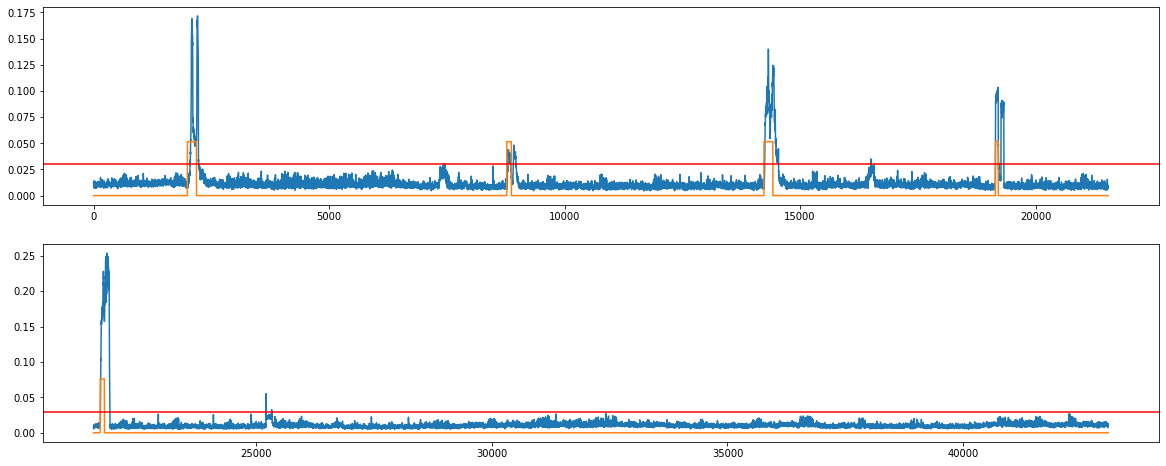

In [147]:
THRESHOLD = 0.03
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [148]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [149]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (43082,))

In [150]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.3)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [151]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [152]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 5.08 s, sys: 4.61 ms, total: 5.08 s
Wall time: 5.09 s


In [153]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [154]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.903 (TaP: 0.827, TaR: 0.994)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


In [155]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,-4.0334,-0.00231,284.39673,85.74829,10,1119.12622,382.21698,-29.0,0,1,15844.0,0,1,0.09042,18991.0,763.19324,315.48346,14.52789,0,1.25036,35.48279,1985.39734,10051.0,10,1,1,99.98731,10,1118.61084,35.37903,0,92.51556,-26.0,20,3.9907,220.14613,11.86442,54065.0,0,774.0,-224,1,0,-0.00015,92.69160,69.76647,2835.65454,0.27557,-0.00723,70,2835.65454,540833,697.39990,540833,1,2880,83.46329,0,0.09874,27600.0,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,-4.0404,-0.00181,283.47436,85.74829,10,1117.85059,382.21698,-28.0,0,1,15808.0,0,1,0.09042,18991.0,763.19324,315.10199,14.52789,0,1.24944,35.48279,1972.99939,10052.0,10,1,1,100.00000,10,1118.61084,35.37674,0,92.51556,-27.0,20,3.5714,218.23881,11.92675,54073.0,0,773.0,-224,1,0,-0.00015,92.64934,69.74272,2832.98731,0.27634,-0.00723,70,2832.98731,540833,704.41895,540833,1,2880,83.40041,0,0.09874,27600.0,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,-4.0404,0.00007,282.69678,85.74829,10,1118.48840,382.21698,-23.0,0,1,15734.0,0,1,0.09042,18991.0,763.19324,316.05570,14.52026,0,1.24746,35.48279,1981.58276,10052.0,10,1,1,99.98115,10,1118.61084,35.37178,0,92.51556,-27.0,20,3.5714,216.90367,11.92675,54073.0,0,773.0,-224,1,0,0.00007,92.91075,69.77000,2842.25244,0.27634,-0.00723,70,2842.25244,540833,704.41895,540833,1,2880,83.34054,0,0.09874,27595.0,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,-3.8861,0.00000,283.04034,85.74829,10,1117.85059,382.21698,-29.0,0,1,15710.0,0,1,0.09042,18991.0,763.19324,315.10199,14.51263,0,1.24624,35.48279,1979.86585,10053.0,10,1,1,100.00000,10,1118.61084,35.36873,0,92.51556,-27.0,20,3.3456,221.67204,11.96341,54086.0,0,777.0,-224,1,0,-0.00015,92.92407,69.70607,2833.12744,0.27557,-0.00723,70,2833.12744,540833,704.35791,540833,1,2880,83.26884,0,0.09874,27590.0,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,-3.6790,-0.00029,281.99145,85.63384,10,1119.44507,382.21698,-29.0,0,1,15608.0,0,1,0.09042,18992.0,763.19324,315.48346,14.52026,0,1.24364,35.48279,1977.19556,10052.0,10,1,1,100.00000,10,1118.61084,35.36224,0,92.51556,-26.0,20,3.2272,218.23881,11.99236,54086.0,0,778.0,-224,1,0,0.00007,93.05405,69.76971,2839.44482,0.27710,-0.00723,70,2839.44482,540833,700.89111,540833,1,2880,83.18826,0,0.09874,27588.0,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,-3.4769,-0.00231,431.51404,40.38391,10,983.98590,417.58124,-22.0,0,1,19259.0,0,1,71.14441,7140.0,763.19324,240.17335,8.83636,0,1.45290,37.89367,6.14166,10052.0,10,1,1,0.00000,10,989.50207,35.97946,0,3.39661,-20.0,20,3.9836,168.64778,11.87761,54088.0,0,787.0,15248,1,0,-0.00022,3.67038,47.56297,32.97053,0.20462,71.67969,70,31.97761,540833,705.32837,540833,1,2880,40.20410,0,0.06112,27627.0,824.82147,10

In [156]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.95).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,0.487693,0.198263,0.808607,0.0,0.899123,0.159596,-0.000366,0.0,0.0,0.225073,0.0,0.0,0.000418,0.949670,0.0,0.880684,0.504186,0.0,0.274269,0.092179,0.989424,0.329327,0.0,0.0,0.0,0.999873,0.0,0.985637,0.264512,0.0,0.924960,-0.000513,0.0,0.574677,0.482436,0.343670,0.431818,0.0,0.316456,0.003422,0.0,0.0,0.581043,0.926916,0.844788,0.992272,0.048368,0.000000,0.0,0.992272,0.0,0.359459,0.0,0.0,0.0,0.779812,0.0,0.955389,0.707071,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.169051,0.000999,0.299303,0.430806,0.010417,0.137330,0.492326,0.194993,0.808607,0.0,0.894813,0.159596,-0.000192,0.0,0.0,0.222676,0.0,0.0,0.000418,0.949670,0.0,0.878190,0.504186,0.0,0.273476,0.092179,0.983525,0.331616,0.0,0.0,0.0,0.999994,0.0,0.985637,0.264022,0.0,0.924960,-0.000758,0.0,0.428924,0.478718,0.539928,0.460678,0.0,0.304400,0.003422,0.0,0.0,0.581043,0.926514,0.843993,0.991375,0.048705,0.000000,0.0,0.991375,0.0,0.414521,0.0,0.0,0.0,0.779015,0.0,0.955389,0.707071,0.680720,0.0,0.317842,0.450637,0.230052,0.944440,0.222985,0.198409,0.26162,0.647029
2,0.272777,0.0,0.0,0.828325,0.166351,0.000926,0.298378,0.435413,0.010417,0.137209,0.509923,0.192087,0.808607,0.0,0.896758,0.159596,0.000685,0.0,0.0,0.217646,0.0,0.0,0.000418,0.949670,0.0,0.884290,0.503929,0.0,0.271736,0.092179,0.987319,0.331725,0.0,0.0,0.0,0.999821,0.0,0.985637,0.262939,0.0,0.924960,-0.000770,0.0,0.422000,0.475946,0.549251,0.462049,0.0,0.303828,0.003422,0.0,0.0,0.583498,0.928978,0.844866,0.994440,0.048721,0.000000,0.0,0.994440,0.0,0.417137,0.0,0.0,0.0,0.778219,0.0,0.955389,0.659085,0.677873,0.0,0.318315,0.451255,0.229746,0.944440,0.220058,0.196787,0.26162,0.643813
3,0.273199,0.0,0.0,0.828325,0.157999,0.000995,0.357049,0.484714,0.010417,0.192992,0.510154,0.193158,0.808607,0.0,0.894705,0.159596,-0.000313,0.0,0.0,0.215801,0.0,0.0,0.000418,0.949670,0.0,0.878377,0.503660,0.0,0.270600,0.092179,0.986693,0.334014,0.0,0.0,0.0,0.999991,0.0,0.985637,0.262234,0.0,0.924960,-0.000770,0.0,0.343360,0.485078,0.664859,0.508898,0.0,0.351901,0.003422,0.0,0.0,0.581166,0.929228,0.842776,0.991532,0.048385,0.000000,0.0,0.991532,0.0,0.416790,0.0,0.0,0.0,0.777273,0.0,0.955389,0.608712,0.675638,0.0,0.318338,0.449373,0.229731,0.944440,0.218811,0.193648,0.26162,0.579676
4,0.272751,0.0,0.0,0.828325,0.175122,0.000999,0.371173,0.561204,0.010417,0.270660,0.507486,0.189502,0.807146,0.0,0.899977,0.159596,-0.000363,0.0,0.0,0.208934,0.0,0.0,0.000418,0.949734,0.0,0.880568,0.503903,0.0,0.268308,0.092179,0.985395,0.331845,0.0,0.0,0.0,1.000000,0.0,0.985637,0.260812,0.0,0.924960,-0.000526,0.0,0.298375,0.478860,0.761565,0.511240,0.0,0.366329,0.003422,0.0,0.0,0.583504,0.930475,0.844795,0.993506,0.049036,0.000000,0.0,0.993506,0.0,0.389644,0.0,0.0,0.0,0.776206,0.0,0.955389,0.587001,0.683000,0.0,0.317867,0.450958,0.229730,0.944440,0.212597,0.199160,0.26162,0.519859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619542,0.0,0.0,0.073426,0.534081,0.998079,0.475668,0.585227,0.017422,0.354759,0.488420,0.745805,0.199385,0.0,0.419506,0.612529,0.000905,0.0,0.0,0.463744,0.0,0.0,0.820283,0.142583,0.0,0.363357,0.302727,0.0,0.457546,0.533385,0.000676,0.331593,0.0,0.0,0.0,0.000000,0.0,0.428804,0.399473,0.0,0.031439,0.001027,0.0,0.562801,0.377094,0.400358,0.525768,0.0,0.482123,0.830582,0.0,0.0,0.580350,0.036717,0.065072,0.002789

In [157]:
boundary_check(TEST_DF)

(True, True, False)

In [158]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 358328


{'answer': tensor([5.0099e-01, 0.0000e+00, 0.0000e+00, 1.7481e-01, 2.9587e-01, 3.0731e-04,
         4.2806e-01, 2.5797e-01, 5.7870e-04, 1.9646e-01, 4.9188e-01, 7.2836e-01,
         2.5512e-01, 0.0000e+00, 4.2098e-01, 4.3588e-01, 3.3090e-02, 0.0000e+00,
         0.0000e+00, 4.0540e-01, 0.0000e+00, 0.0000e+00, 7.6127e-01, 6.2065e-01,
         0.0000e+00, 3.5714e-01, 2.6897e-01, 0.0000e+00, 4.2076e-01, 2.7931e-02,
         9.8437e-01, 3.3413e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.8759e-01, 0.0000e+00, 9.9916e-01, 2.5674e-04,
         0.0000e+00, 5.7570e-01, 3.8642e-01, 1.4524e-01, 6.0227e-01, 0.0000e+00,
         4.3038e-01, 7.7759e-01, 0.0000e+00, 0.0000e+00, 5.8022e-01, 1.0000e+00,
         1.5259e-01, 9.9262e-01, 4.9071e-02, 8.2592e-01, 0.0000e+00, 9.9153e-01,
         0.0000e+00, 4.4633e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6248e-01,
         0.0000e+00, 9.9751e-01, 3.5354e-01, 6.0440e-01, 0.0000e+00, 3.5133e-01,
         2.0199e-0

In [159]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 30.3 s, sys: 6.07 s, total: 36.4 s
Wall time: 36.4 s


In [160]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

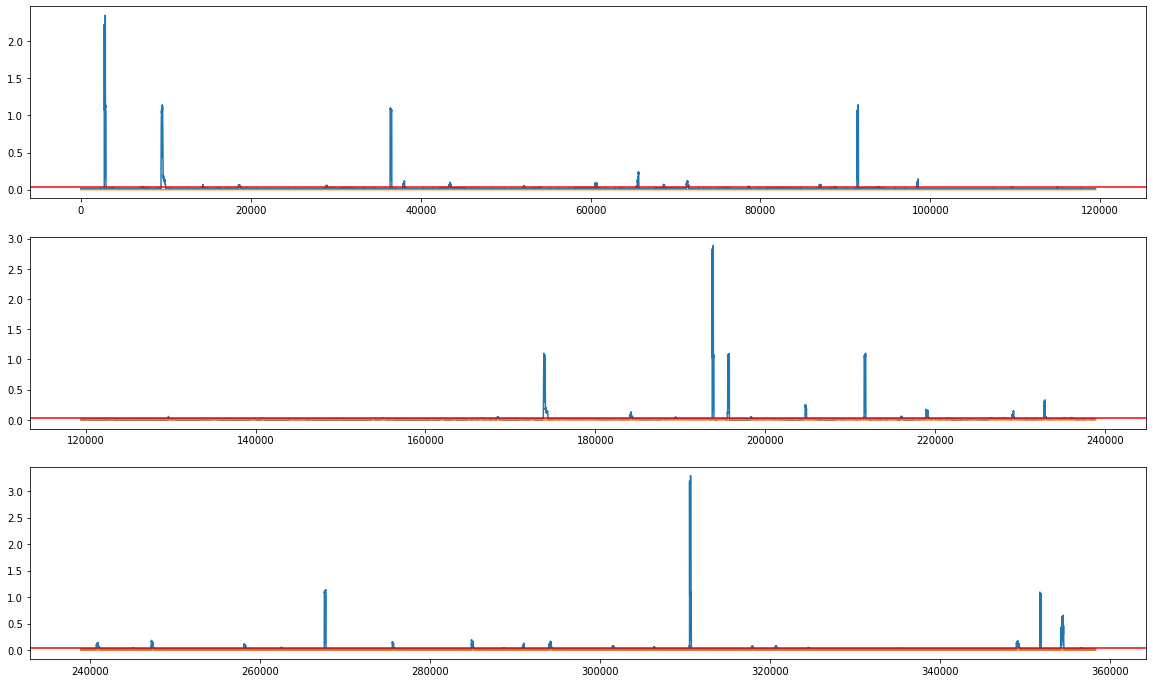

In [161]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [162]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (358328,))

In [163]:
submission = pd.read_csv('sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0.0
2020-07-31 12:29:57,2020-07-31 12:29:57,0.0
2020-07-31 12:29:58,2020-07-31 12:29:58,0.0


In [164]:
submission.to_csv('baseline.csv', index=False)